# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [31]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import datetime
from scipy import stats

## Generate Cities List

In [2]:
# Need the following library to get a list of cities
# I performed a 'pip install citypy' to obtain the library
from citipy import citipy
from random import uniform

# Procedure to return a random lat and long coordinate
def newpoint():
   return uniform(-180,180), uniform(-90, 90)

# Find the closest city to each random coordinate (800)
cities = [] 
while len(cities) < 600:
    point = newpoint()
    city = citipy.nearest_city(point[0], point[1]).city_name
    # check if the city is not already chosen
    if city not in cities:
        cities.append(city)
    
# Check city count = 600
print(len(cities))

600


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
from api_keys import weather_api_key

url = "http://api.openweathermap.org/data/2.5/weather?"
units='imperial'

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

# set up lists to hold reponse info
citynum = []
cityname = []
citytemp = []
cityhumidity = []
citylatitude = []
citycloudiness = []
citywindspeed = []

x = 0
valid_cities = 0

# Get weather data
for city in cities:
    x += 1
    try:
        response = requests.get(query_url + city).json()
        print(f"Processing record {x}: {response['name']} id={response['id']}")
        valid_cities +=1
        citynum.append(valid_cities)
        cityname.append(city)
        citytemp.append(response['main']['temp'])
        cityhumidity.append(response['main']['humidity'])
        citylatitude.append(response['coord']['lat'])
        citycloudiness.append(response['clouds']['all'])
        citywindspeed.append(response['wind']['speed'])
    except KeyError:
        print(f"Processing record {x}: {city} - No weather details available")
    
    # Break out of loop when we have enough weather records
    if valid_cities > 520:
        break

113: Chui id=3443061
Processing record 114: Cidreira id=3466165
Processing record 115: Camocim id=3403687
Processing record 116: Stranraer id=2636719
Processing record 117: Torbay id=6167817
Processing record 118: Gopālpur id=1270961
Processing record 119: Podporozh'ye id=508034
Processing record 120: Pauini id=3662927
Processing record 121: louisbourg - No weather details available
Processing record 122: Phalombe id=924206
Processing record 123: Hithadhoo id=1282256
Processing record 124: Mossamedes id=3347019
Processing record 125: Swanton id=5173514
Processing record 126: Kamenka id=553766
Processing record 127: São João da Barra id=3448903
Processing record 128: Karad id=1267904
Processing record 129: Henties Bay id=3356832
Processing record 130: amderma - No weather details available
Processing record 131: Bonavista id=5905393
Processing record 132: Iqaluit id=5983720
Processing record 133: Tiznit Province id=2527087
Processing record 134: Bull Savanna id=3491161
Processing record

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
weather_dict = {
    "Number": citynum,
    "City": cityname,
    "Latitude": citylatitude,
    "Temp": citytemp,
    "Humidity" : cityhumidity,
    "Cloudiness" : citycloudiness,
    "Windspeed" : citywindspeed 
}

weather_data = pd.DataFrame(weather_dict)
weather_data

,Number,City,Latitude,Temp,Humidity,Cloudiness,Windspeed
0,1,caconda,-13.7333,57.07,83,72,0.76
1,2,ushuaia,-54.8000,48.20,87,75,8.05
2,3,grand gaube,-20.0064,84.99,74,14,8.99
3,4,outjo,-20.1167,61.38,53,76,6.67
4,5,hamirpur,25.9500,69.48,30,0,4.88
...,...,...,...,...,...,...,...
516,517,kyabe,9.4515,72.90,24,0,4.14
517,518,hammerfest,70.6634,19.40,93,40,8.61
518,519,tabou,4.4230,77.52,89,1,4.83
519,520,tharad,24.3961,78.15,17,0,3.80


In [5]:
weather_data.to_csv("output_data\weather_data.csv", index=False)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
high_humidity = weather_data.loc[weather_data['Humidity']>100]
high_humidity.head()

,Number,City,Latitude,Temp,Humidity,Cloudiness,Windspeed


In [9]:
#  Get the indices of cities that have humidity over 100%.
high_humidity_index = high_humidity.index

In [10]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = weather_data.drop(high_humidity_index, inplace=False)
len(clean_city_data)

521

In [11]:
clean_city_data = clean_city_data.reset_index(inplace=False)
clean_city_data = clean_city_data[['City', 'Latitude', 'Temp', 'Humidity', 'Cloudiness', 'Windspeed']]
clean_city_data.head()

,City,Latitude,Temp,Humidity,Cloudiness,Windspeed
0,caconda,-13.7333,57.07,83,72,0.76
1,ushuaia,-54.8000,48.20,87,75,8.05
2,grand gaube,-20.0064,84.99,74,14,8.99
3,outjo,-20.1167,61.38,53,76,6.67
4,hamirpur,25.9500,69.48,30,0,4.88


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [12]:
now = datetime.date.today().strftime('%d-%b-%Y')

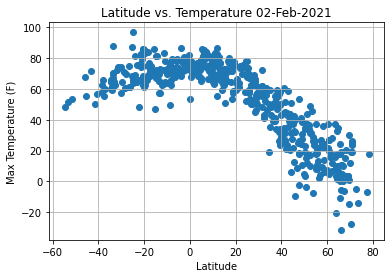

In [13]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Temp)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeTemp.png")
plt.show()

## Latitude vs. Humidity Plot

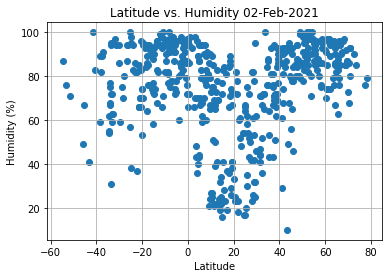

In [14]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Humidity)
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeHumidity.png")
plt.show()

## Latitude vs. Cloudiness Plot

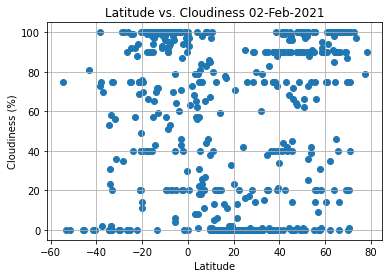

In [15]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Cloudiness)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Latitude vs. Cloudiness {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeCloud.png")
plt.show()

## Latitude vs. Wind Speed Plot

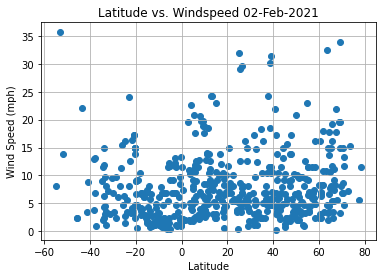

In [16]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Windspeed)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Latitude vs. Windspeed {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeWind.png")
plt.show()

## Linear Regression

In [17]:
north_hemisphere = clean_city_data.loc[clean_city_data.Latitude > 0]
south_hemisphere = clean_city_data.loc[clean_city_data.Latitude < 0]

print(f"North = {len(north_hemisphere)} records, South = {len(south_hemisphere)} records")

North = 361 records, South = 160 records


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.8102171498731584


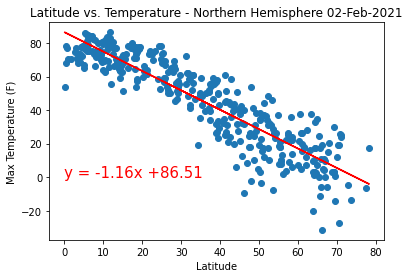

In [45]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Temp
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatTempRegression.png")

plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.1997859704492127


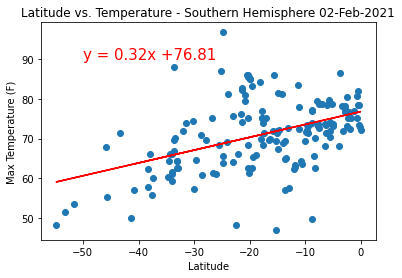

In [46]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Temp
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,90),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatTempRegression.png")

plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.22449611752841506


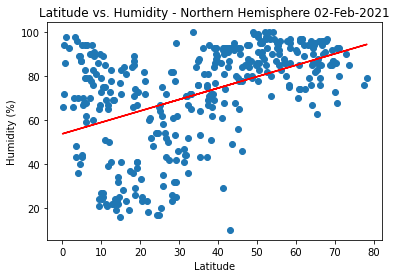

In [47]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Humidity
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatHumidRegression.png")

plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.12929221019117182


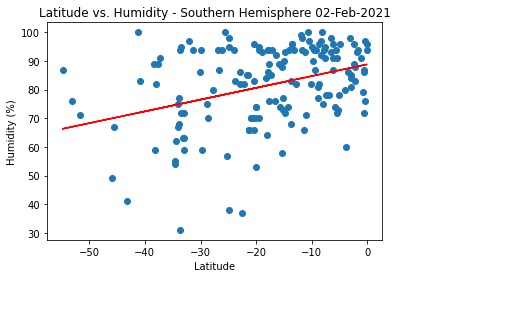

In [48]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Humidity
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatHumidRegression.png")

plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.16395190075382662


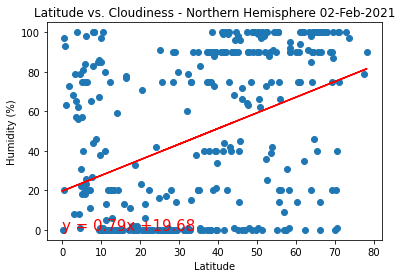

In [49]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Cloudiness
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Cloudiness - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatCloudRegression.png")

plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.1671824241262153


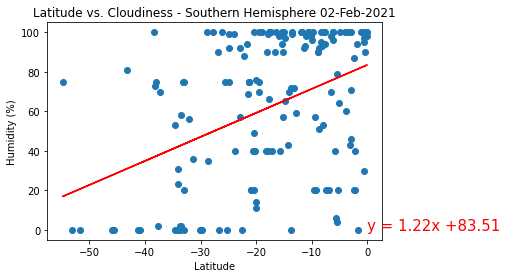

In [50]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Cloudiness
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Cloudiness - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatCloudRegression.png")

plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.0011925054214773922


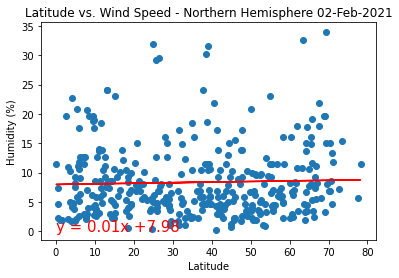

In [51]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Windspeed
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Wind Speed - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatWindRegression.png")

plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.09371549223314976


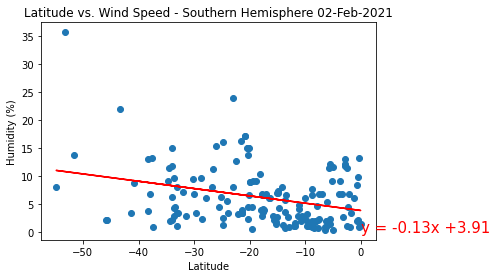

In [52]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Windspeed
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Wind Speed - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatWindRegression.png")

plt.show()